# **Task 1: Build two recommender systems:**
###**1. The first one is to recommend the top 5 movies based on a given movie title.**
###**2. The second model will estimate the rating of a movie based on the user behaviour.**

# **What is a Recommendation System?**
Simply put a Recommendation System is a filtration program whose prime goal is to predict the “rating” or “preference” of a user towards a domain-specific item or item. 

#**What are the different filtration strategies?**
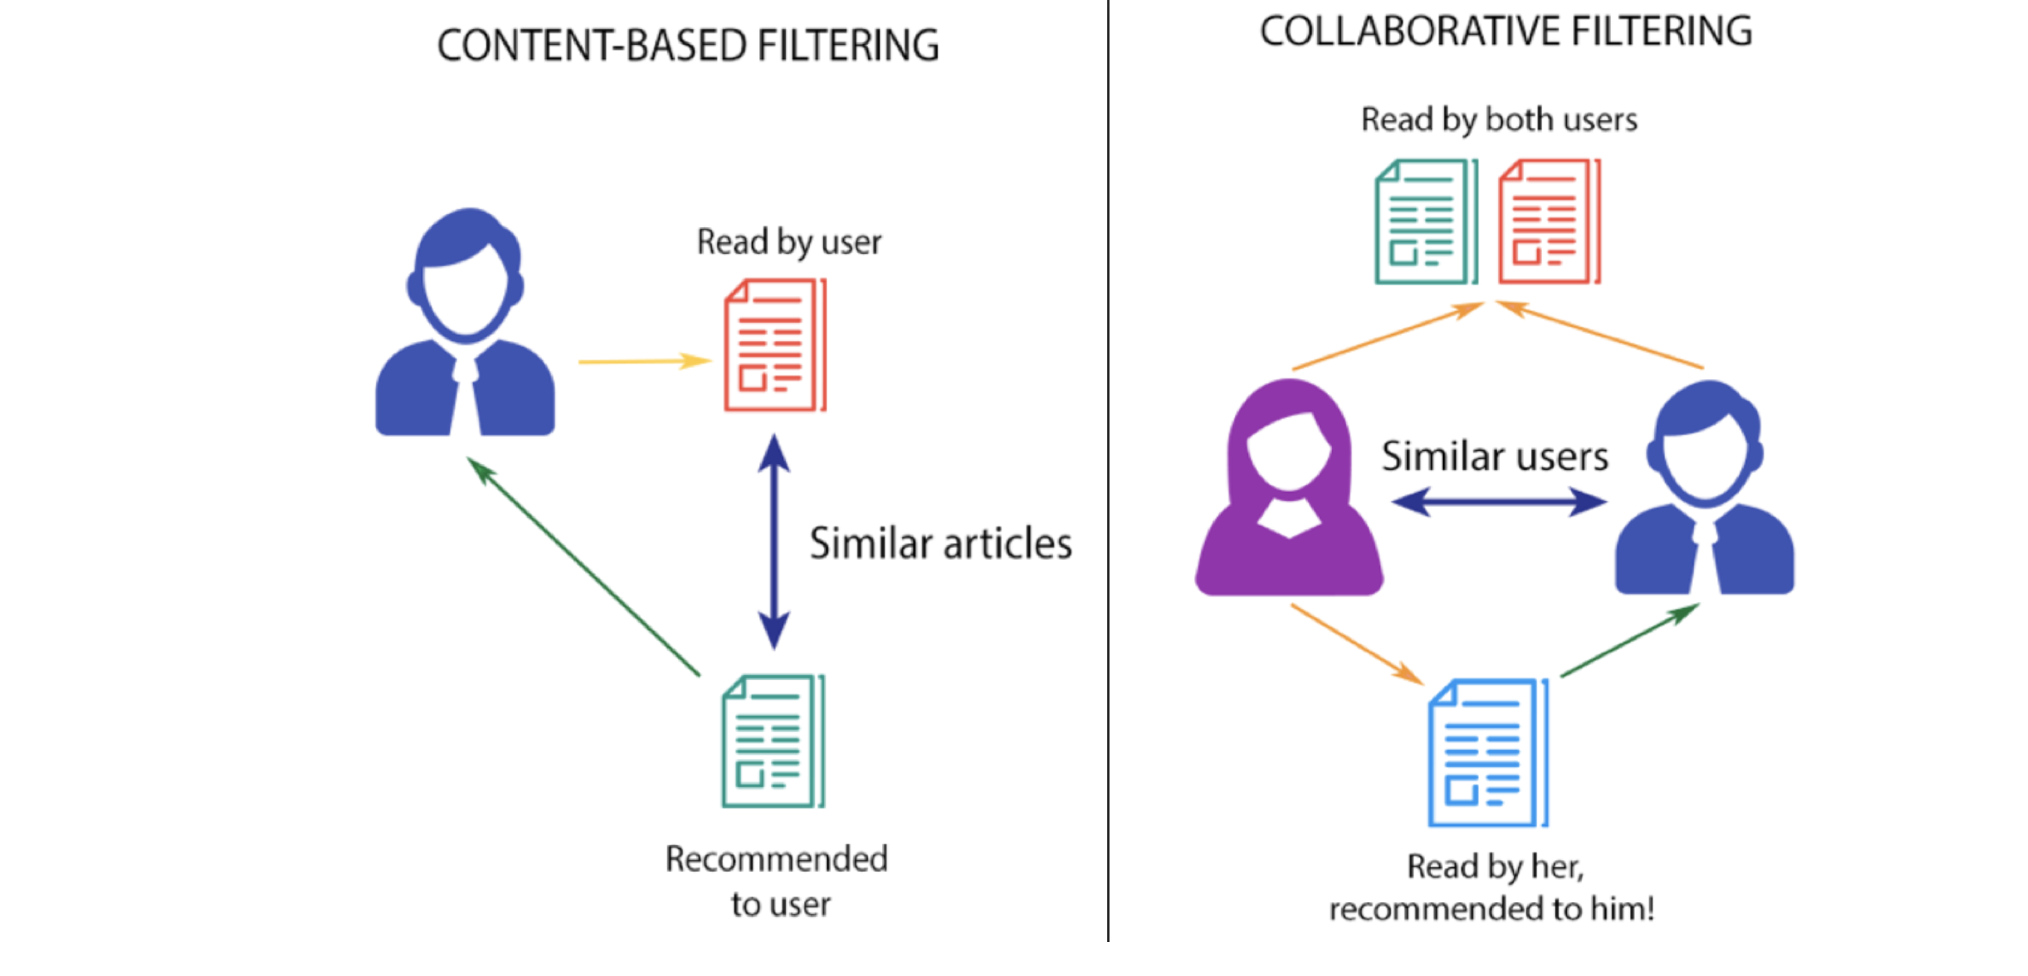


#**There are 2 types of collaborative filtering algorithms:**

###**1. User-based Collaborative filtering**

The basic idea here is to find users that have similar past preference patterns as the user ‘A’ has had and then recommending him or her items liked by those similar users which ‘A’ has not encountered yet. 
> ### **Disadvantages**

>1. People are fickle-minded i.e their taste change from time to time.

>2. There are many more users than items therefore it becomes very difficult to maintain such large matrices and therefore needs to be recomputed very regularly.

>3. This algorithm is very susceptible to shilling attacks where fake users profiles consisting of biased preference patterns are used to manipulate key decisions.
###**2. Item-based Collaborative Filtering**
The concept in this case is to find similar movies instead of similar users and then recommending similar movies to that ‘A’ has had in his/her past preferences. This is executed by finding every pair of items that were rated/viewed/liked/clicked by the same user, then measuring the similarity of those rated/viewed/liked/clicked across all user who rated/viewed/liked/clicked both, and finally recommending them based on similarity scores.


> ### **Advantages over User-based Collaborative Filtering:**
>1. Unlike people’s taste, movies don’t change.

>2. There are usually a lot fewer items than people, therefore easier to maintain and compute the matrices.
>3. Shilling attacks are much harder because items cannot be faked.
 
##**Let’s start coding up our own Movie recommendation system**
In this implementation recommend the top 5 movies based on a given movie title. 
I will be using an item-based collaborative filtering algorithm for our purpose. The dataset used in this demonstration is the Movie Lens Small Latest Dataset.

Getting the data up and running
##**1. Import libraries**

In [ ]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 54 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1626195 sha256=d43fffa4937556d7fc0d767d56224089ca0f5019a31dc272fffbb2a130a59785
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors as knn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict #data colector
import surprise
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import NMF

np.random.seed(42) # replicating results

##**2. Load the data**

In [ ]:
movies = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/movies.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/ratings.csv")

##**Let’s have a look at the movies dataset :**

In [ ]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


###Movie dataset has:

###**movieId** – once the recommendation is done, we get a list of all similar movieId and get the title for each movie from this dataset.
###**genres** – which is not required for this filtering approach.


In [ ]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


###Ratings dataset has:

**userId** – unique for each user.

**movieId** – using this feature when take the title of the movie from the movies dataset.

**rating** – Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies.

###To make things easier to understand and work with, we are going to make a new dataframe where each column would represent each unique userId and each row represents each unique movieId.

In [ ]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.fillna(0,inplace=True)
final_dataset.head(3)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


### Now, it’s much easier to interpret that userId 1 has rated movieId 1& 3 4.0 but has not rated movieId 3,4,5 at all (therefore they are represented as 0.0 ) and therefore their rating data is missing.
##**3. Removing Noise from the data**
We wouldn’t take into account:
>movies that were rated by a small number of users because it’s not credible enough. 

>Users who have rated only a handful of movies should also not be taken into account.


**So let's add some filters for the final dataset.**
>To qualify a movie, a minimum of 10 users should have voted a movie.

>To qualify a user, a minimum of 50 movies should have voted by the user.


In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count') #Aggregating the number of users who voted 
no_movies_voted = ratings.groupby('userId')['rating'].agg('count') #and the number of movies that were voted.

###**Let’s visualize:**
> ### **the number of users who voted with our threshold of 10.**
> ### **the number of votes by each user with our threshold of 50.**

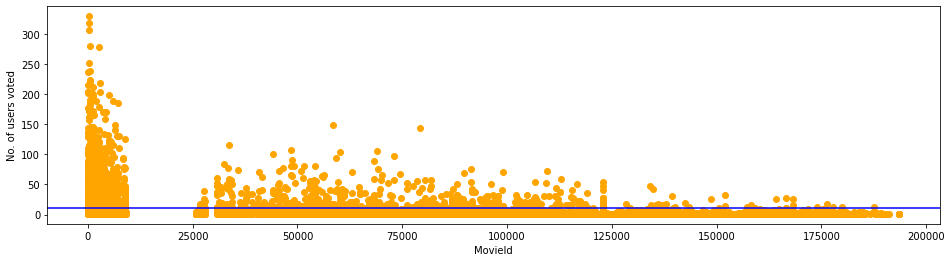

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='orange')
plt.axhline(y=10,color='blue')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

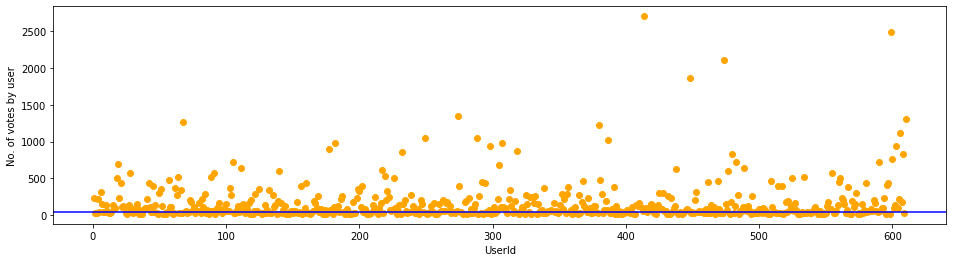

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='orange')
plt.axhline(y=50,color='blue')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

###**Now let's make the necessary modifications as per the threshold set.**

In [ ]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 2].index,:] #final dataset-->where each column represent userId
                                                                             #and each row represents movieId.
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 5].index]
final_dataset.shape

(4980, 610)

##**4. Removing sparsity**
Our final_dataset has dimensions of 2121 * 378 where most of the values are sparse. 
To reduce the sparsity we use the csr_matrix function from the scipy library.

 I’ll give an example of how it works :


In [ ]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


##**Applying the csr_matrix method to the dataset :**


In [ ]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

# **1.1 Making the movie recommendation system model**
We will be using the KNN algorithm to compute similarity with  metric.
##**Making the recommendation function**
First check if the movie name input is in the database and, **If** it is we use our recommendation system to find similar movies and sort them based on their similarity distance and output only the top 5 movies with their distances from the input movie.


In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 5
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

#**Finally, Let’s Recommend some movies!**

In [ ]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Avatar (2009),0.375732
2,Iron Man 2 (2010),0.358014
3,"Avengers, The (2012)",0.341324
4,WALL·E (2008),0.332225
5,"Dark Knight, The (2008)",0.329462


In [ ]:
get_movie_recommendation('Memento')

,Title,Distance
1,"Lord of the Rings: The Two Towers, The (2002)",0.348358
2,Eternal Sunshine of the Spotless Mind (2004),0.346196
3,"Matrix, The (1999)",0.326215
4,"Lord of the Rings: The Fellowship of the Ring,...",0.316777
5,Fight Club (1999),0.272380


#**1.2 The second model will estimate the rating of a movie based on the user behaviour.**


#**I will use the same datase**

In [ ]:
movies_df = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/movies.csv")
ratings_df = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/ratings.csv")

In [ ]:
min_movie_ratings = 10 #a movie has was rated at least 
min_user_ratings =  50 #a user rated movies at least

ratings_flrd_df = ratings_df.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)

In [ ]:
ratings_flrd_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

#**Data Loading**
While using Surprise, define a Reader object to parse the file or the dataframe by Surprise. 

Surprise also allows to upload pandas' DataFrame. 

Lastly, build_full_trainset() method builds the training set from the entire data set.

In [ ]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId",	"movieId",	"rating"]], reader=reader)

trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()


In [ ]:
ratings_flrd_df.shape

(73868, 4)

In [ ]:
print(trainset)
type(trainset)

surprise.trainset.Trainset

In [ ]:
len(testset)

758855

In [ ]:
testset[:5]

[(1, 21, 3.554996750961174),
 (1, 32, 3.554996750961174),
 (1, 45, 3.554996750961174),
 (1, 52, 3.554996750961174),
 (1, 58, 3.554996750961174)]

##**Non-Negative Matrix Factorization (NMF)**
###**Choose hyperparameters**

In [ ]:
param_grid = {'n_factors': [11,14,15,16,17,18,20]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8680061574535751
{'n_factors': 16}


In [ ]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset) ##call .fit_transform -->https://github.com/scikit-learn/scikit-learn/blob/844b4be24d20fc42cc13b957374c718956a0db39/benchmarks/bench_plot_nmf.py#L246
                       ##.fit_transform return Transformed data. ##--> call _fit_projected_gradient
                       ## return W, H, n_iter
                       ##https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF
                       

# Predict ratings for all pairs (u, i) that are NOT in the training set.
#testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [ ]:
type(predictions)

list

In [ ]:
predictions[:5]

[Prediction(uid=1, iid=21, r_ui=3.554996750961174, est=4.193618827815818, details={'was_impossible': False}),
 Prediction(uid=1, iid=32, r_ui=3.554996750961174, est=4.958632648585701, details={'was_impossible': False}),
 Prediction(uid=1, iid=45, r_ui=3.554996750961174, est=4.083512276825836, details={'was_impossible': False}),
 Prediction(uid=1, iid=52, r_ui=3.554996750961174, est=3.936468443240915, details={'was_impossible': False}),
 Prediction(uid=1, iid=58, r_ui=3.554996750961174, est=4.616189358009761, details={'was_impossible': False})]

In [ ]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
    '''
    #Peart I.: Surprise docomuntation
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

In [ ]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)


User 124 has already rated 50 movies.


In [ ]:
pred_NMF_124

,userId,movieId,rat_pred,title,genres
0,124,1136,5.000000,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
1,124,1283,5.000000,High Noon (1952),Drama|Western
2,124,3030,5.000000,Yojimbo (1961),Action|Adventure
3,124,1945,5.000000,On the Waterfront (1954),Crime|Drama
4,124,1172,5.000000,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
5,124,2360,5.000000,"Celebration, The (Festen) (1998)",Drama
6,124,2318,5.000000,Happiness (1998),Comedy|Drama
7,124,7099,4.988223,Nausicaä of the Valley of the Wind (Kaze no ta...,Adventure|Animation|Drama|Fantasy|Sci-Fi
8,124,3334,4.954967,Key Largo (1948),Crime|Drama|Film-Noir|Thriller
9,124,96821,4.947275,"Perks of Being a Wallflower, The (2012)",Drama|Romance


# **2. Topic Modelling**
**b. Choose either the twitter dataset or the newsgroup dataset or combine them used in the above resources “i” and “ii”. It’s your own choice but you should describe the merits and demerits of combining the two datasets if you do so.**

**c. Build a topic modelling algorithm using NMF model either using Scikit-Learn or your implementation or any other library.**

**d. Given a sentence, create a function that will return the top 3 topics using NMF.**

**e. Compare the performance of the NMF model against LDA “Latent Dirichlet Allocation”. Choose the appropriate metric. “Perplexity, Pearson, or Coherence, ...”**

**f. You are not asked to describe the inner steps of LDA at all.**

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. 

We will need the stopwords from NLTK and spacy’s en model for text pre-processing (spacy model for lemmatization).

Lemmatization is converting a word to its root word. (e.g. the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on).

In [ ]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##**Import Packages**




In [ ]:
# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
# model building package
import sklearn

# package to clean text
import re

### Next we will read in this dataset and have a look at it.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ourcodingclub/CC-topic-modelling-python/master/climate_tweets.csv')
df.head(2)

,tweet
0,Global warming report urges governments to act...
1,Fighting poverty and global warming in Africa ...


In [ ]:
df.tweet[0]

'Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]'

##**2. EDA - Time to start exploring our dataset**

In [ ]:
df.shape

(6090, 1)

So we have 6090 tweets 

##**Finding Retweets**
There are tweets that start with ‘RT’ and hence how many of them are retweets. Use the lines below to find out how many retweets there are in the dataset.

In [ ]:
# make a new column to highlight retweets
df['is_retweet'] = df['tweet'].apply(lambda x: x[:2]=='RT')
df['is_retweet'].sum()  # number of retweets

773

In [ ]:
df.head(2)

,tweet,is_retweet
0,Global warming report urges governments to act...,False
1,Fighting poverty and global warming in Africa ...,False


In [ ]:
 # number of unique retweets
df.loc[df['is_retweet']].tweet.unique().size

677

### **Let's see the popular tweets by counting the number of times that each tweet is repeated in our dataframe, and sort by the number of times that each tweet appears. Then look at the top 10 tweets.**





In [ ]:
# 10 most repeated tweets
df.groupby(['tweet']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,tweet,counts
3131,No matter if you believe in global warming or ...,20
4555,Take Action @change: Help Protect Wildlife Hab...,14
4027,RT @newtgingrich: Historic snow storm in washi...,9
1765,Fight Climate Change From All Fronts: [link],8
1626,Earth's polar ice sheets vulnerable to even mo...,7
1941,Global Warming Dent's El Ni'o's Protective Shi...,7
1799,Foes of California's global warming law pour m...,6
1351,Coalition of the Tired of Waiting: Fighting Cl...,6
4271,SCIENCE: Scientists explore the evolution of c...,6
1040,Carbon offsets: How a Vatican forest failed to...,6


### **Then, let's see how the number-of-copies of each tweet are distributed.**




> Indented block



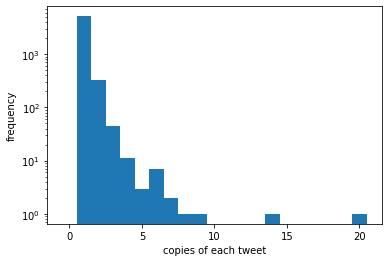

In [ ]:
# number of times each tweet appears
counts = df.groupby(['tweet']).size()\
           .reset_index(name='counts')\
           .counts

# define bins for histogram
my_bins = np.arange(0,counts.max()+2, 1)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('copies of each tweet')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

##**3. @who? #what? - Extracting substrings with regular expressions from each tweet**

In [ ]:
#who is being retweeted (if any)
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet) ##re package can be used to extract 
                                                                    ##or replace certain patterns in string data in Pytho
#who is being tweeted at/mentioned (if any)
def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

#what hashtags are being used (if any)
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

##**Let's try**

In [ ]:
# two sample tweets
my_tweet = 'RT @our_codingclub: Can @you find #all the #hashtags?'
my_other_tweet = 'Not a retweet. All views @my own'

In [ ]:
print(find_hashtags(my_tweet))
print(find_mentioned(my_tweet))
print(find_retweeted(my_tweet))

['#all', '#hashtags']
['@you']
['@our_codingclub']


In [ ]:
print(find_hashtags(my_other_tweet))
print(find_mentioned(my_other_tweet))
print(find_retweeted(my_other_tweet))

[]
['@my']
[]


##**Now going to make 3 new columns in our dataframe**:
 

In [ ]:
#each entry in these new columns will contain a list rather than a single value
df['retweeted'] = df.tweet.apply(find_retweeted) # new column for retweeted usernames
df['mentioned'] = df.tweet.apply(find_mentioned) # new column for mentioned usernames
df['hashtags'] = df.tweet.apply(find_hashtags)   # new column for hashtags

In [ ]:
df.tail(2)

,tweet,is_retweet,retweeted,mentioned,hashtags
6088,One-Eyed Golfer: Don't dare tell me about glob...,False,[],[],[]
6089,man made global warming a hair brained theory ...,False,[],[],"[#tcot, #p2, #climategate]"


##**4. Keyword Correlations in Text**
Now, we want to know who is highly retweeted, who is highly mentioned, and what popular hashtags are going around.

First we will select the column of hashtags from the dataframe, and take only the rows where there actually is a hashtag

In [ ]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]
hashtags_list_df.head(2)                                   

,hashtags
12,"[#Climate, #population]"
16,[#EarthDay]


In [ ]:
highly_mentioned_list_df = df.loc[df.mentioned.apply(lambda mentioned_list: mentioned_list !=[]),['mentioned']]
highly_retweeted_list_df = df.loc[df.retweeted.apply(lambda retweeted_list: retweeted_list !=[]),['retweeted']]

In [ ]:
# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame([hashtag for hashtags_list in hashtags_list_df.hashtags 
                                      for hashtag in hashtags_list],columns=['hashtag'])
flattened_hashtags_df.head()

,hashtag
0,#Climate
1,#population
2,#EarthDay
3,#ac
4,#tcot


###**Now, let's find the unique number of hashtags.**

In [ ]:
flattened_hashtags_df['hashtag'].unique().size # number of unique hashtags

477

###**Like before lets look at the top hashtags by their frequency of appearance.**

In [ ]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags.head(3)                                       

,hashtag,counts
0,#tcot,227
1,#climate,202
2,#p2,112


##**From Text to Vector**
Before we do this we will want to limit to hashtags that appear enough times to be correlated with other hashtags. We can’t correlate hashtags which only appear once, and we don’t want hashtags that appear a low number of times since this could lead to spurious correlations.


In [ ]:
# take hashtags which appear at least this amount of times
min_appearance = 10
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts>=min_appearance]['hashtag'])

###**Next, create a new column in hashtags_df which filters the hashtags to only the popular hashtags.**
###**We will also drop the rows where no popular hashtags appear.**

In [ ]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]


In [ ]:
popular_hashtags_list_df.shape

(786, 2)

In [ ]:
hashtags_list_df.shape

(1129, 2)

In [ ]:
popular_hashtags_list_df.head(3)

,hashtags,popular_hashtags
12,"[#Climate, #population]",[#Climate]
16,[#EarthDay],[#EarthDay]
31,[#tcot],[#tcot]


### To find which of our hashtags are correlated with each other,  we will need to turn the text into numeric form. 
### For example if our available hashtags were the set [#photography #pets, #funny, #day], then the tweet ‘#funny #pets’ would be [0,1,1,0] in vector form.
###Let's vectorise our the hashtags in each tweet like mentioned above, by creating a dataframe where the hashtags contained in each row are in vector form.


In [ ]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

In [ ]:
hashtag_vector_df.head(3)

,popular_hashtags,#TCOT,#snowpocalypse,#EarthDay,#fb,#IPCC,#du1,#agw,#cochabamba,#FoxNews,#sgp,#News,#earthday,#SierraClub,#teaparty,#ocra,#climategate,#gop,#news,#climatechange,#Climate,#cleantech,#globalwarming,#environment,#climate,#energy,#global,#Green,#p2,#eco,#GlobalWarming,#tcot,#tlot,#UN,#SaveTerra,#green
12,[#Climate],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,[#EarthDay],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31,[#tcot],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


###**Now we will drop the popular_hashtags column from the dataframe. We don’t need it.**


In [ ]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

###**Then, let's find the correlation between each column of the dataframe and thus the correlation between the different hashtags appearing in the same tweets.**

We will use the seaborn package that we imported earlier to plot the correlation matrix as a heatmap

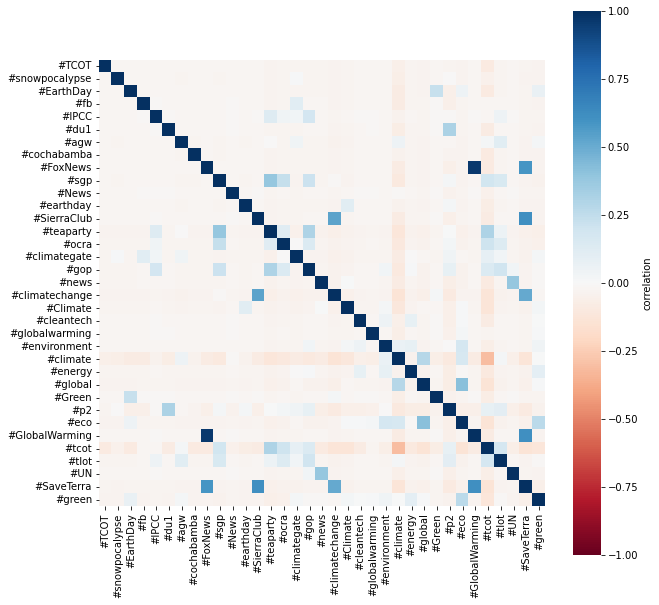

In [ ]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

From the plot above we can see that there are fairly strong correlations between: 
>#SaveTerra and #SierraClub

>#GloablWarming and #FoxNews

We can also see a fairly strong negative correlation between:

>#tcot and #climate

##**5. Introduction to Topic Modelling**
We will be using latent dirichlet allocation (LDA) and  non-negative matric factorisation (NMF).

The important information to know is that these techniques each take a matrix which is similar to the hashtag_vector_df dataframe that we created above. 
Every row represents a tweet and every column represents a word. The entry at each row-column position is the number of times that a given word appears in the tweet for the row, this is called the bag-of-words format. 
For the word-set [#photography, #pets, #funny, #day], the tweet ‘#funny #funny #photography #pets’ would be [1,1,2,0] in vector form.

Using this matrix the topic modelling algorithms will form topics from the words. 
Each of the algorithms does this in a different way, but the basics are that the algorithms look at the co-occurrence of words in the tweets and if words often appearing in the same tweets together, then these words are likely to form a topic together. The algorithm will form topics which group commonly co-occurring words. 
A topic in this sense, is just list of words that often appear together and also scores associated with each of these words in the topic. 
The higher the score of a word in a topic, the higher that word’s importance in the topic. Each topic will have a score for every word found in tweets, in order to make sense of the topics we usually only look at the top words - the words with low scores are irrelevant.
For example, from a topic model built on a collection on marine research articles might find the topic: 

>asteroidea, starfish, legs, regenerate, ecological, marine, asexually, …

and the accompanying scores for each word in this topic could be:

>900, 666, 523, 503, 392, 299, 127, …
We can see that this seems to be a general topic about starfish, but the important part is that we have to decide what these topics mean by interpreting the top words. 

##**6. Cleaning Unstructured Text Data**

First we will start with imports for this specific cleaning task.

We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

We will need to use nltk.download('stopwords') command to download the stopwords if you have not used nltk before.
##**In the cell below some functions to remove web-links from the tweets.**


In [ ]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [ ]:
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

##**Use the cleaning function above to make a new column of cleaned tweets. Set bigrams = False for the moment to keep things simple. This is something you could come back to later. Print this new column see if you can understand the gist of what each tweet is about.**


In [ ]:
df['clean_tweet'] = df.tweet.apply(clean_tweet)

In [ ]:
df.tail()

,tweet,is_retweet,retweeted,mentioned,hashtags,clean_tweet
6085,"@bloodless_coup ""The phrase 'global warming' s...",False,[],[@bloodless_coup],"[#p2, #tcot]",phrase global warm abandon favor climat chang...
6086,Virginia to Investigate Global Warming Scienti...,False,[],[],[],virginia investig global warm scientist mann
6087,Global warming you tube parody you will enjoy ...,False,[],[],"[#IPCC, #ocra]",global warm tube parodi enjoy #ipcc #ocra
6088,One-Eyed Golfer: Don't dare tell me about glob...,False,[],[],[],one eye golfer dare tell global warm twenti fi...
6089,man made global warming a hair brained theory ...,False,[],[],"[#tcot, #p2, #climategate]",man made global warm hair brain theori scient...


##**7. Applying Topic Modelling**
**To turn the text into a matrix, where each row in the matrix encodes which words appeared in each individual tweet:**
>#We will also filter the words max_df=0.9 means we discard any words that appear in >90% of tweets. 
>#We will also filter words using min_df=25, so words that appear in less than 25 tweets will be discarded. 
>#We discard high appearing words since they are too common to be meaningful in topics. 
>#We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['clean_tweet']).toarray() # #term frequency’ - the frequency of each word/token in each tweet). 

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

##**Note that the tf matrix is exactly like the hashtag_vector_df dataframe. Each row is a tweet and each column is a word. The numbers in each position tell us how many times this word appears in this tweet.**


In [ ]:
tf #term frequency’ The shape of tf tells us how many tweets we have 
   ##and how many words we have that made it through our filtering process.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

##**Next we actually create the model object. Lets start by arbitrarily choosing 10 topics. We also define the random state so that this model is reproducible.**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [ ]:
model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

Next we will want to inspect our topics that we generated and try to extract meaningful information from them.

Below I have written a function which takes in our model object model, the order of the words in our matrix tf_feature_names and the number of words we would like to show. Use this function, which returns a dataframe, to show you the topics we created. Remember that each topic is a list of words/tokens and weights

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)
    

In [ ]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,climat,1220.2,global,666.5,global,1147.2,global,473.1,climat,422.0,global,783.0,chang,666.1,warm,167.9,climat,568.3,climat,529.9
1,chang,1184.5,warm,658.1,warm,1102.1,warm,450.7,chang,401.8,warm,764.7,climat,661.6,#climate,139.2,chang,550.5,chang,520.6
2,via,257.9,snow,160.5,scientist,150.2,believ,101.3,legisl,123.2,gore,137.1,energi,178.8,volcano,128.9,new,321.1,peopl,153.4
3,scienc,112.9,#tcot,121.6,say,87.1,california,87.1,us,105.1,snow,123.7,u,109.8,global,128.6,bill,116.9,world,151.3
4,news,79.5,like,99.0,scienc,71.7,blame,82.1,via,60.5,al,122.1,via,96.5,chang,122.0,senat,106.1,confer,110.1
5,day,77.8,blizzard,90.9,debat,66.6,law,78.6,say,55.9,great,94.1,nation,89.0,help,114.1,agenc,95.1,bill,106.4
6,earth,68.2,dc,86.5,man,61.1,report,77.8,video,55.9,cold,77.1,make,74.5,take,96.8,immigr,77.7,talk,94.8
7,trial,68.1,think,83.3,made,54.0,save,61.8,place,54.1,call,76.5,impact,67.5,climat,76.7,obama,75.6,graham,92.1
8,clinic,68.1,due,80.1,show,51.9,money,56.1,good,52.6,#tcot,75.3,report,63.4,iceland,67.1,feder,67.1,un,77.6
9,carbon,64.5,make,70.4,water,50.6,live,49.3,human,48.2,one,72.1,issu,58.8,could,64.5,via,58.6,put,68.8


In [ ]:
from sklearn.decomposition import NMF
from sklearn import metrics

In [ ]:
model_NMF = NMF(n_components=10, random_state=0, alpha=.1, l1_ratio=.5) 
model_NMF.fit(tf)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=10, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
display_topics(model_NMF, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,climat,10.8,global,9.3,via,7.7,snow,5.4,bill,5.2,new,6.0,#climate,4.9,peopl,3.8,say,4.4,#tcot,5.6
1,chang,9.8,warm,9.1,news,1.5,dc,1.9,senat,2.5,agenc,1.9,chang,4.6,world,3.4,report,3.3,#p,1.7
2,energi,0.3,make,0.3,humanitarian,0.6,gore,1.4,graham,1.6,obama,1.2,#global,1.0,earth,2.3,caus,2.4,#teaparty,1.0
3,scienc,0.3,could,0.2,chang,0.4,al,1.3,put,1.1,feder,1.2,#eco,0.8,confer,2.2,scientist,1.8,#gop,0.6
4,fight,0.3,scienc,0.2,india,0.3,mean,1.2,limbo,0.8,form,1.0,warm,0.7,right,1.3,us,1.0,scam,0.6
5,legisl,0.3,think,0.2,com,0.2,jr,1.0,exit,0.8,studi,0.7,us,0.4,bolivia,1.0,govern,0.8,dc,0.6
6,u,0.3,stop,0.2,un,0.1,storm,1.0,climat,0.7,administr,0.7,fact,0.3,day,1.0,may,0.8,gore,0.5
7,un,0.3,effect,0.2,environ,0.1,cold,0.9,compromis,0.7,propos,0.6,nasa,0.3,mother,1.0,u,0.4,#ocra,0.5
8,get,0.2,volcano,0.2,mean,0.1,washington,0.9,prepar,0.7,york,0.6,#p,0.3,indigen,0.4,carbon,0.3,al,0.5
9,action,0.2,believ,0.2,impact,0.1,ago,0.9,immigr,0.6,report,0.5,thought,0.3,cochabamba,0.3,china,0.3,#tlot,0.5


In [ ]:
pip install gensim


In [ ]:
!pip install --upgrade gensim

In [ ]:
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.nmf import Nmf 

===================================================================================================================

In [ ]:
pip install pyLDAvis

In [ ]:
pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
pip install --upgrade jupyter notebook


     |████████████████████████████████| 9.9 MB 5.0 MB/s            
     |████████████████████████████████| 428 kB 66.9 MB/s            
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: notebook
    Found existing installation: notebook 5.3.1
    Uninstalling notebook-5.3.1:
      Successfully uninstalled notebook-5.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook~=5.3.0; python_version >= "3.0", but you have notebook 6.4.4 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.3 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf as GensimNmf


# spacy for lemmatization
import spacy


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#**Prepare StopWords**

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#**1. Import Newsgroups Data**




In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


#**1.1 Remove emails and newline characters**
As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [ ]:
# Convert to list
data = df.content.values.tolist()
pprint(data[:1])

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[0:1])

["From: lerxst@wam.umd.edu (where's my thing)\n"
 'Subject: WHAT car is this!?\n'
 'Nntp-Posting-Host: rac3.wam.umd.edu\n'
 'Organization: University of Maryland, College Park\n'
 'Lines: 15\n'
 '\n'
 ' I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.\n'
 '\n'
 'Thanks,\n'
 '- IL\n'
 '   ---- brought to you by your neighborhood Lerxst ----\n'
 '\n'
 '\n'
 '\n'
 '\n']
['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wond

#**1.2 Tokenize words and Clean-up text**

#**We need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.**

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


#**2. Creating Bigram and Trigram Models**
**Bigrams** are two words frequently occurring together in the document. 
**Trigrams** are 3 words frequently occurring.
Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


#**3. Remove Stopwords, Make Bigrams and Lemmatize**
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.



In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


##**Let’s call the functions in order.**



In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


##**4. Create the Dictionary and Corpus needed for Topic Modeling**
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.



In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized 

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] #corpus is a stream of input documents = training examples:
                                                   #bow -->bag-of-words format -> mapping of (word_id, word_frequency).
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


##**As we can see above: For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on. This is used as the input by the LDA model.**

#**5. Building the Topic Model**
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#**View the topics in LDA model**
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.049*"year" + 0.023*"last" + 0.023*"team" + 0.021*"game" + 0.021*"first" + '
  '0.017*"go" + 0.016*"next" + 0.016*"play" + 0.015*"win" + 0.014*"start"'),
 (1,
  '0.076*"church" + 0.053*"cpu" + 0.041*"turkish" + 0.036*"son" + '
  '0.032*"armenian" + 0.027*"upgrade" + 0.021*"inhabitant" + 0.019*"escape" + '
  '0.019*"soul" + 0.018*"proceed"'),
 (2,
  '0.262*"ax" + 0.222*"max" + 0.075*"character" + 0.037*"font" + '
  '0.020*"trivial" + 0.012*"plot" + 0.012*"click" + 0.004*"rushdie" + '
  '0.004*"precedent" + 0.001*"islamic_law"'),
 (3,
  '0.124*"law" + 0.048*"israeli" + 0.036*"format" + 0.036*"jewish" + '
  '0.032*"state" + 0.030*"citizen" + 0.030*"willing" + 0.022*"waste" + '
  '0.019*"party" + 0.019*"homosexual"'),
 (4,
  '0.041*"patient" + 0.029*"body" + 0.024*"police" + 0.023*"eat" + '
  '0.021*"safety" + 0.021*"route" + 0.020*"cool" + 0.019*"treatment" + '
  '0.019*"meet" + 0.019*"disease"'),
 (5,
  '0.022*"may" + 0.017*"make" + 0.014*"people" + 0.013*"also" + 0.012*"many" +

##**How to interpret this?**

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.
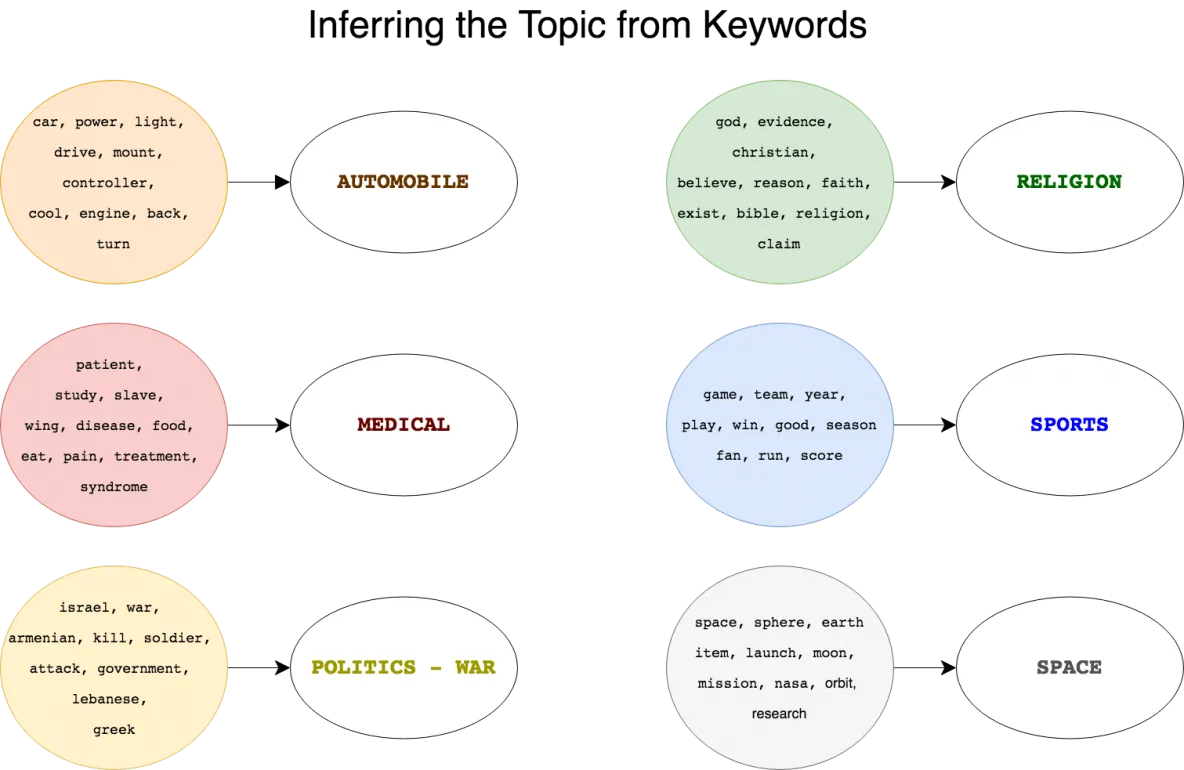

##**5. Compute Model Perplexity and Coherence Score**
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.



In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.89426769844373

Coherence Score:  0.46006848849944637


#**Using NMF**

In [ ]:
nmf = GensimNmf(
    corpus=corpus,
    num_topics=20,
    id2word=id2word,
    chunksize=100,
    passes=10,
    eval_every=10,
    minimum_probability=0,
    random_state=100,
    kappa=1,
)

In [ ]:
# Print the Keyword in the 10 topics
pprint(nmf.print_topics())
doc_nmf = nmf[corpus]

[(0,
  '0.024*"gun" + 0.014*"law" + 0.012*"firearm" + 0.010*"state" + 0.010*"right" '
  '+ 0.009*"file" + 0.009*"article" + 0.008*"crime" + 0.007*"report" + '
  '0.007*"issue"'),
 (1,
  '0.015*"may" + 0.014*"entry" + 0.012*"atheist" + 0.009*"many" + 0.009*"must" '
  '+ 0.009*"make" + 0.009*"believe" + 0.008*"exist" + 0.007*"religion" + '
  '0.006*"question"'),
 (2,
  '0.051*"write" + 0.047*"line" + 0.026*"article" + 0.014*"output" + '
  '0.011*"read" + 0.009*"open" + 0.009*"program" + 0.009*"host" + '
  '0.008*"return" + 0.007*"name"'),
 (3,
  '0.036*"drive" + 0.017*"system" + 0.014*"scsi" + 0.013*"use" + '
  '0.012*"problem" + 0.012*"bit" + 0.010*"window" + 0.010*"driver" + '
  '0.010*"support" + 0.009*"run"'),
 (4,
  '0.102*"would" + 0.012*"could" + 0.012*"think" + 0.009*"good" + 0.008*"be" + '
  '0.008*"make" + 0.007*"time" + 0.007*"know" + 0.006*"really" + 0.006*"seem"'),
 (5,
  '0.022*"come" + 0.019*"go" + 0.015*"take" + 0.014*"could" + 0.013*"see" + '
  '0.013*"know" + 0.011*"apa

In [ ]:
# Compute Coherence Score
coherence_model_nmf = CoherenceModel(model=nmf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score: ', coherence_nmf)


Coherence Score:  0.5517586888246168


#**6.Conclusion**
Coherence measures the relative distance between words within a topic. There are two major types C_V typically 0 < x < 1 and uMass -14 < x < 14. It's rare to see a coherence of 1 or +.9 unless the words being measured are either identical words or bigrams. Like United and States would likely return a coherence score of ~.94 or hero and hero would return a coherence of 1. The overall coherence score of a topic is the average of the distances between words. I try and attain a .7 in my LDAs if I'm using c_v I think that is a strong topic correlation. I would say:
Coherence Score:  0.5 for NMF
Coherence Score:  0.4 for LDA
so, NMF is better than LDA for topic modeling.

=================================================================================================================


#**5. K-means suffers a lot when the dataset is not flat**
**a.** Please apply the necessary techniques - perhaps such as kernels - on the moons dataset found in Scikit-Learn to make it possible to cluster the dataset successfully. A bonus question: is there a method in Scikit-Learn other than Spectral Clustering - like the DBSCAN method which depends on the Nearest Neighbour techniques or an Agglomerative method - that can do this trick for you? Explain please. “Read the user guide of the clustering page on Scikit-Learn website”

**b.** Choose two unsupervised metric techniques and evaluate the K-means
output before and after applying the techniques in point “a”. One of the techniques should not require a label to be evaluated.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn import cluster, datasets
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
np.random.seed(0)

#**Create the moons dataset**

kmeans_model  silhouette_score =  0.3533206614452746
kmeans_model  fowlkes_mallows_score =  0.4993765482488766
-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Kernel_model  silhouette_score =  0.11376923544156349
Kernel_model  fowlkes_mallows_score =  1.0
-----------------------------------------------------------------
kmeans_model  silhouette_score =  0.49796795262964616
kmeans_model  fowlkes_mallows_score =  0.7390862022704245
-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Kernel_model  silhouette_score =  0.39165963587311126
Kernel_model  fowlkes_mallows_score =  1.0
-----------------------------------------------------------------
kmeans_model  silhouette_score =  0.42653894065789577
kmeans_model  fowlkes_mallows_score =  0.9841070355136174
-----------------------------------------------------------------
Kernel_model  silhouette_score =  0.4261006648868427
Kernel_model  fowlkes_mallows_score =  0.9841070355136174
-----------------------------------------------------------------


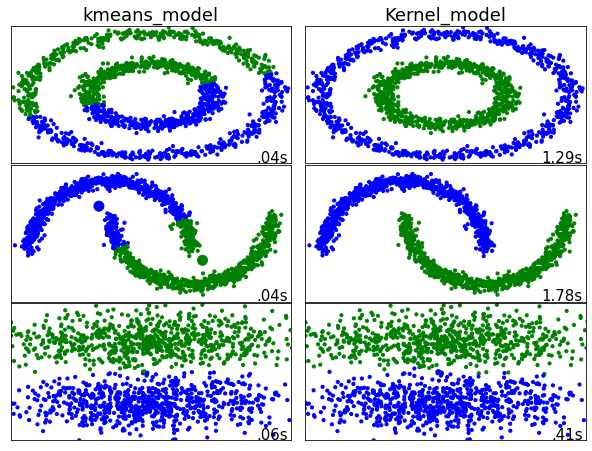

In [ ]:
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, centers =2,cluster_std=2,random_state=8)

colors = np.array(['blue','green','yellow','purple'])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(8,8))
plt.subplots_adjust(left=.001, right=.999, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
for i_dataset, dataset in enumerate([noisy_circles, noisy_moons, blobs]):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Compute distances
    #distances = np.exp(-euclidean_distances(X))
    distances = euclidean_distances(X)

    # create clustering estimators
    kmeans_model = KMeans(n_clusters=2, random_state=1)
    Kernel_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',assign_labels='kmeans')
    
    for name, algorithm in [
                            ('kmeans_model', kmeans_model),
                            ('Kernel_model', Kernel_model)
                           ]:
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        print(name," silhouette_score = ", metrics.silhouette_score(X, algorithm.labels_, metric='euclidean'))
        print(name," fowlkes_mallows_score = ", metrics.fowlkes_mallows_score(y, y_pred))
        print('-----------------------------------------------------------------')
        # plot
        plt.subplot(4, 2, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

##**k-means is limited to linear cluster boundaries**
###The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

###In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. 
###It is clear from the cluster labels found by the typical k-means approach by using  the moons data with different shapes we have used.
###This is reminiscent of the SVM, where it uses a kernel transformation to project the data into a higher dimension where a linear separation is possible. By using the same ide to allow k-means to discover non-linear boundaries.

### One version of this kernelized k-means is implemented in Scikit-Learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data and then assigns labels using a k-means algorithm

#**I've selected two different Unsupervised metrics to compare between K-means and the Specteral Clustering**
# One of the requre the require the knowledge of the ground truth classes (lables):
#**1. Fowlkes-Mallows scores:**
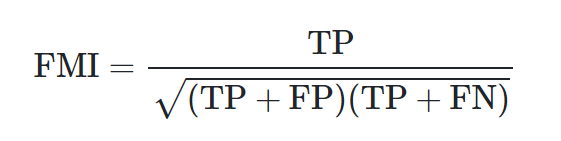

The score ranges from 0 to 1. A high value indicates a good similarity between two clusters.




# And the other metric doesn't require a label to be evaluated.
#**2.Silhouette Coefficient**
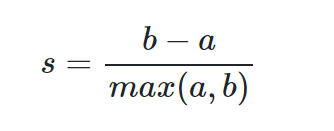

**a:** The mean distance between a sample and all other points in the same class.

**b:** The mean distance between a sample and all other points in the next nearest cluster.
The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.



#**Thank you!**